# Access CELLxGENE collaboration embeddings (scVI, Geneformer)

This notebook demonstrates basic access to CELLxGENE collaboration embeddings of CELLxGENE Discover Census. Currently, embeddings from scVI and a fine-tuned Geneformer model are maintained by CELLxGENE Discover. There are other CELLxGENE-hosted embeddings contributed by the community to CELLxGENE Discover, find out more about these in the [Census model page](https://cellxgene.cziscience.com/census-models).

**IMPORTANT:** This tutorial requires cellxgene-census package version 1.9.1 or later.

**Contents**

1. Quick start
1. Storage format
1. Query cells and load associated embeddings

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).


## Quick start

CELLxGENE collaboration embeddings can easily be exported into an AnnData as shown below for any slice of Census. This example queries all cells from tongue tissue. 

⚠️ Note that Geneformer embeddings are only available for human data

In [1]:
import cellxgene_census

emb_names = ["scvi", "geneformer"]
census_version = "2023-12-15"

with cellxgene_census.open_soma(census_version=census_version) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism="homo_sapiens",
        measurement_name="RNA",
        obs_value_filter="tissue == 'tongue'",
        obs_embeddings=emb_names,
    )

In [2]:
adata

AnnData object with n_obs × n_vars = 372 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi', 'geneformer'

In [3]:
adata.obsm

AxisArrays with keys: scvi, geneformer

## Storage format

Each embedding is encoded as a SOMA SparseNDArray, where:

* dimension 0 (`soma_dim_0`) encodes the cell (obs) `soma_joinid` value
* dimension 1 (`soma_dim_1`) encodes the embedding feature, and is in the range [0, N) where N is the number of features in the embedding
* data (`soma_data`) is float32

The first axis of the embedding array will have the same shape as the corresponding `obs` DataFrame for the Census build and experiment. The second axis of the embedding will have a shape (0, N) where N is the number of features in the embedding.

Embedding values, while stored as a float32, are precision reduced. Currently they are equivalent to a bfloat16, i.e., have 8 bits of exponent and 7 bits of mantissa.

## Query cells and load associated embeddings

This section demonstrates several methods to query cells from the Census by `obs` metadata, and then fetch embeddings associated with each cell.


### Loading embeddings into an AnnData `obsm` slot

There are two main ways to load CELLxGENE collaboration embeddings into an AnnData.

1. Via `cellxgene_census.get_anndata()`.
2. With a lazy query via `ExperimentAxisQuery`.

#### AnnData embeddings via `cellxgene_census.get_anndata()`

This is the simplest way of getting the embeddings. In this example we create an AnnData for all "central nervous system" cells.

In [4]:
import warnings

import cellxgene_census
import scanpy

warnings.filterwarnings("ignore")

census_version = "2023-12-15"
census = cellxgene_census.open_soma(census_version=census_version)

emb_names = ["scvi", "geneformer"]

adata = cellxgene_census.get_anndata(
    census,
    organism="homo_sapiens",
    measurement_name="RNA",
    obs_value_filter="tissue_general == 'central nervous system'",
    column_names={"obs": ["cell_type"]},
    obs_embeddings=emb_names,
)

census.close()

Then we can take a quick look at the embeddings in a 2D scatter plot via UMAP.

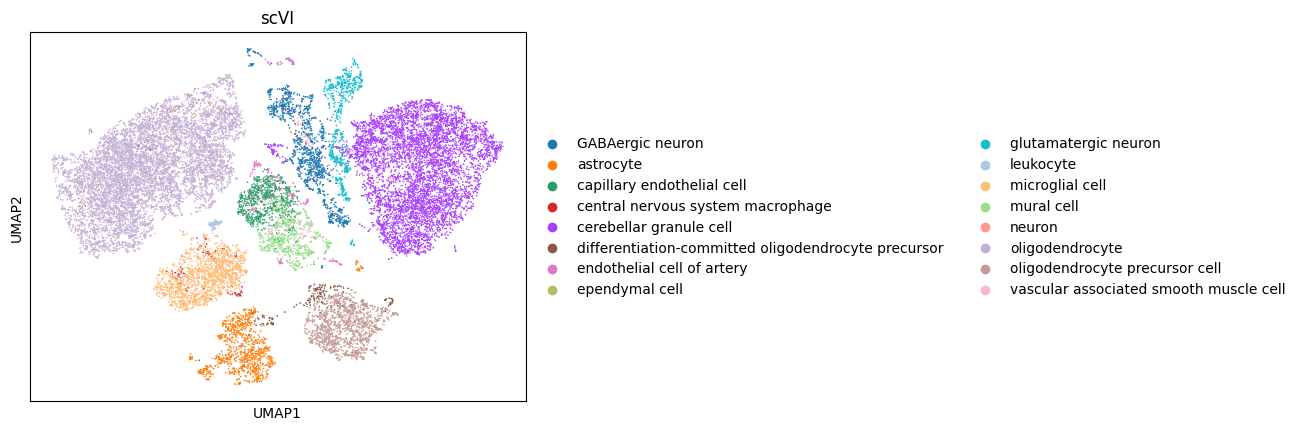

In [5]:
scanpy.pp.neighbors(adata, use_rep="scvi")
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color="cell_type", title="scVI")

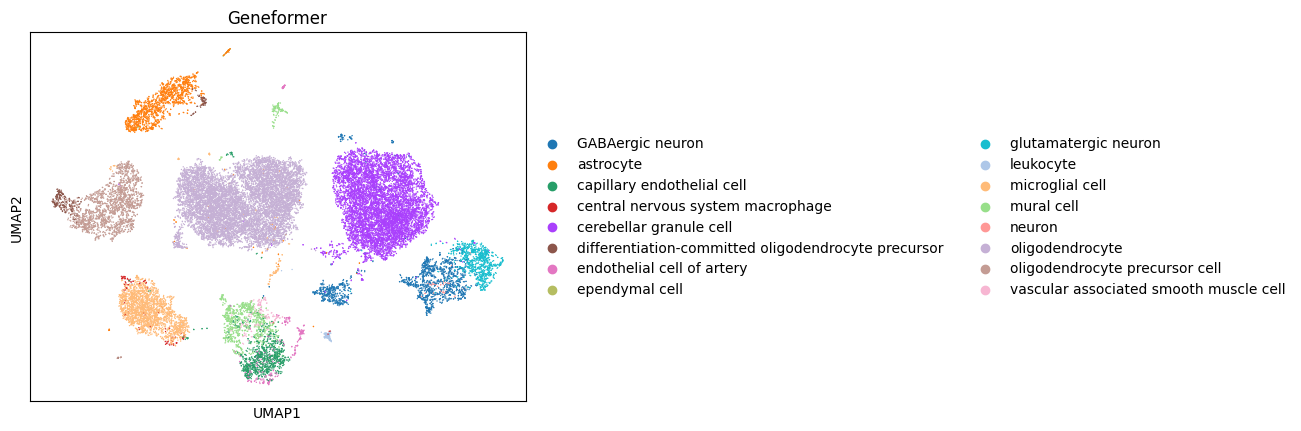

In [6]:
scanpy.pp.neighbors(adata, use_rep="geneformer")
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color="cell_type", title="Geneformer")

#### AnnData embeddings via `ExperimentAxisQuery`

Using an `ExperimentAxisQuery` to get embeddings into an AnnData has the main advantage of inspecting the query in a lazy manner before loading all data into AnnData.

As a reminder this class offers a lazy interface to query Census based on cell and gene metadata, and provides access to the correspondong expression data, cell/gene metadata, and the embeddings.

Let's initiate a lazy query with the same filters as the previous example.

In [7]:
import cellxgene_census
import scanpy
import tiledbsoma as soma

census_version = "2023-12-15"
organism = "homo_sapiens"

census = cellxgene_census.open_soma(census_version=census_version)

experiment = census["census_data"][organism]
query = experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'central nervous system'"),
)

Now, before downloading all the data we can take a look at different attributes, for example the number of cells in our query.

In [8]:
query.n_obs

31780

Then we create an AnnData, retrieve the embeddings and add them to the AnnData's obsm slot:

In [9]:
from cellxgene_census.experimental import get_embedding, get_embedding_metadata_by_name

emb_names = ["scvi", "geneformer"]

adata = query.to_anndata(X_name="raw", column_names={"obs": ["cell_type"]})

for embedding_name in ["scvi", "geneformer"]:
    metadata = get_embedding_metadata_by_name("scvi", "homo_sapiens", census_version=census_version)
    embedding_uri = (
        f"s3://cellxgene-contrib-public/contrib/cell-census/soma/{metadata['census_version']}/{metadata['id']}"
    )
    embedding = get_embedding(metadata["census_version"], embedding_uri, query.obs_joinids().to_numpy())
    adata.obsm[embedding_name] = embedding

adata

AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi', 'geneformer'

In [10]:
adata

AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi', 'geneformer'

In [11]:
query.close()
census.close()

### Load an embedding into a dense NumPy array

To load a  embeddinng into a stand-alone numpy array you can select cells from the Census based on obs metadata, then given the resulting cells, use the `soma_joinid` values to download an embedding, and finally save as a dense NDArray.

Let's first select cells based on cell metadata.

In [12]:
import cellxgene_census
import tiledbsoma as soma

census_version = "2023-12-15"
experiment_name = "homo_sapiens"

census = cellxgene_census.open_soma(census_version=census_version)

obs_df = cellxgene_census.get_obs(
    census,
    experiment_name,
    value_filter="tissue_general == 'central nervous system'",
    column_names=["soma_joinid", "cell_type"],
)

Now you can use the `soma_joinid` values to download the corresponding rows of the embedding matrix via `get_embedding`.

In [13]:
metadata = get_embedding_metadata_by_name("scvi", experiment_name, census_version=census_version)
embedding_uri = f"s3://cellxgene-contrib-public/contrib/cell-census/soma/{metadata['census_version']}/{metadata['id']}"
embedding = get_embedding(metadata["census_version"], embedding_uri, obs_df.soma_joinid.to_numpy())

And now we have a dense matrix with the embedding data.

In [14]:
embedding

array([[-6.17187500e-01,  3.82995605e-03, -7.50000000e-01, ...,
         7.50000000e-01,  9.39941406e-03,  2.71606445e-03],
       [ 3.39843750e-01,  4.71115112e-04, -8.32031250e-01, ...,
         8.00781250e-01, -7.55310059e-04,  8.85009766e-03],
       [ 4.10156250e-01, -2.42614746e-03, -5.00000000e-01, ...,
         9.45312500e-01, -2.53295898e-03,  1.12915039e-02],
       ...,
       [ 3.84765625e-01, -1.54113770e-03, -1.94531250e+00, ...,
        -2.38281250e-01, -1.03149414e-02,  2.28881836e-03],
       [ 8.94531250e-01, -7.14111328e-03,  5.78125000e-01, ...,
        -1.15234375e-01, -2.39562988e-03,  2.42614746e-03],
       [ 6.79687500e-01, -8.48388672e-03,  1.45312500e+00, ...,
        -1.19628906e-01,  6.62803650e-05, -1.88446045e-03]], dtype=float32)

In [16]:
embedding.shape

(31780, 50)

In [17]:
query.close()
census.close()